### Importing relevent libraries

In [1]:
import os
import PIL
import PIL.Image
from pathlib import Path
import tensorflow as tf
import pandas as pd
from livelossplot import PlotLossesKerasTF
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

2.8.3


Check if GPU is availabl.

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Loading data and creating datasets

In [3]:
os.chdir("..")

In [4]:
# Creating paths with data
DATA_DIR = Path('data')
DATA_DIR_TRAIN = DATA_DIR / 'train'
DATA_DIR_TEST = DATA_DIR / 'test_kaggle'

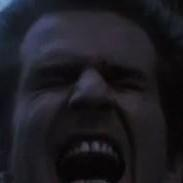

In [5]:
# Checking traim path
anger = list(DATA_DIR_TRAIN.glob('anger/*'))
PIL.Image.open(str(anger[0]))

In [14]:
# Folders with images are structured by classes, so we can use image_dataset_from_directory.
BATCH_SIZE = 64
IMG_HEIGHT = 224
IMG_WIDTH = 224

train_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR_TRAIN,
                                                       label_mode='categorical',
                                                       validation_split=0.2,
                                                       subset='training',
                                                       seed=0,
                                                       image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                       batch_size=BATCH_SIZE)

valid_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR_TRAIN,
                                                       label_mode='categorical',
                                                       validation_split=0.2,
                                                       subset='validation',
                                                       seed=0,
                                                       image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                       batch_size=BATCH_SIZE)

Found 50047 files belonging to 9 classes.
Using 40038 files for training.
Found 50047 files belonging to 9 classes.
Using 10009 files for validation.


In [15]:
# Checking classes
class_names = train_ds.class_names
print(class_names)

['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise', 'uncertain']


In [16]:
emotion_mapping = {k: v for v, k in enumerate(class_names)}
emotion_mapping

{'anger': 0,
 'contempt': 1,
 'disgust': 2,
 'fear': 3,
 'happy': 4,
 'neutral': 5,
 'sad': 6,
 'surprise': 7,
 'uncertain': 8}

In [17]:
# We will use MobileNetV2 pretrained model so we need to preprocess data
def preprocess(images, labels):
    return tf.keras.applications.mobilenet_v2.preprocess_input(images), labels

In [18]:
train_ds = train_ds.map(preprocess)
valid_ds = valid_ds.map(preprocess)

### Creating a model

In [33]:
# Base model on imagenet weights
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
base_model.trainable = False

In [36]:
augmentation_layer = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                          tf.keras.layers.RandomRotation(0.1),
                                          tf.keras.layers.RandomContrast(0.1)])

inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = augmentation_layer(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.AveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)
model_norm_aug = tf.keras.Model(inputs, outputs)

In [37]:
model_norm_aug.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 average_pooling2d_1 (Averag  (None, 3, 3, 1280)       0         
 ePooling2D)                                                     
                                                                 
 flatten_3 (Flatten)         (None, 11520)             0         
                                                                 
 dense_5 (Dense)             (None, 512)               5898

In [38]:
LR = 1e-4
EPOCHS = 5

model_norm_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
                          loss='categorical_crossentropy',
                          metrics=['categorical_accuracy'])

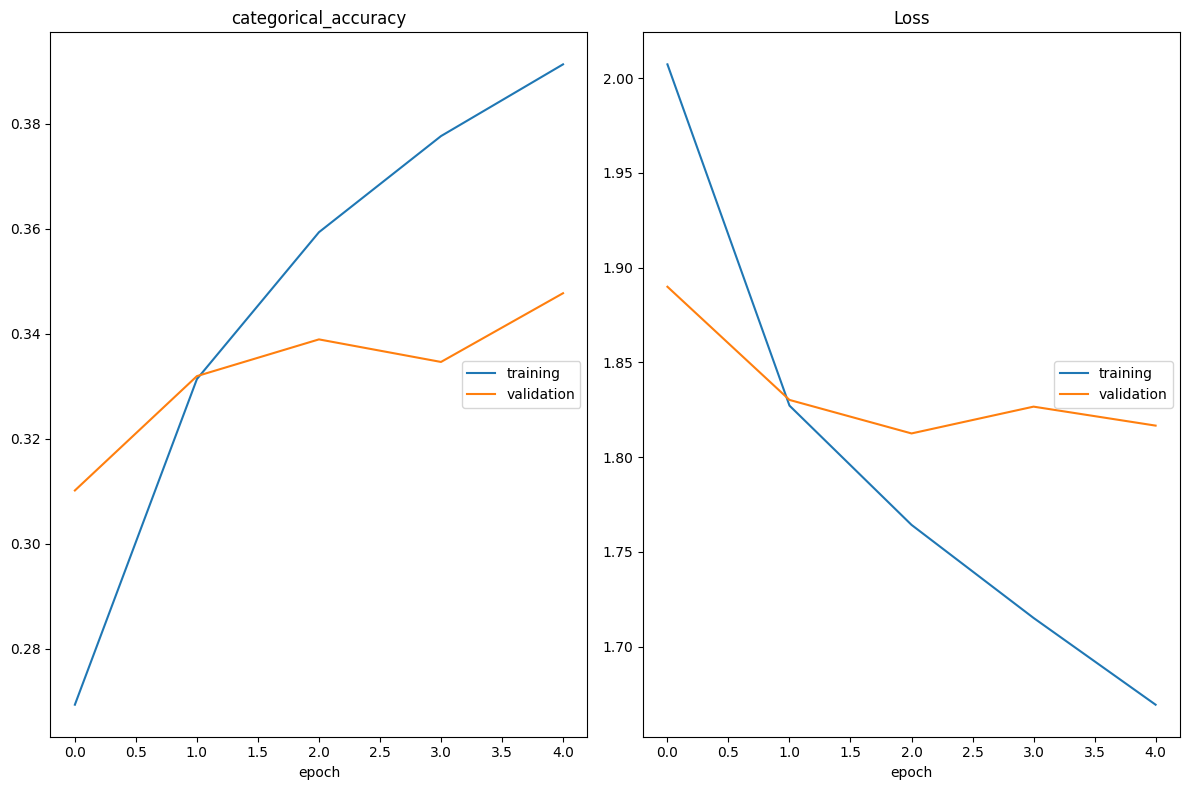

categorical_accuracy
	training         	 (min:    0.269, max:    0.391, cur:    0.391)
	validation       	 (min:    0.310, max:    0.348, cur:    0.348)
Loss
	training         	 (min:    1.669, max:    2.007, cur:    1.669)
	validation       	 (min:    1.813, max:    1.890, cur:    1.817)
626/626 [==============================] - 67s 107ms/step - loss: 1.6693 - categorical_accuracy: 0.3913 - val_loss: 1.8166 - val_categorical_accuracy: 0.3477


In [39]:
history_norm_aug = model_norm_aug.fit(x=train_ds,
                          epochs=EPOCHS,
                          validation_data=valid_ds,
                          callbacks=[PlotLossesKerasTF()])

<b> Accuracy is good, but overfit on 5 epochs.</b>

In [40]:
len(base_model.layers)

154

In [41]:
base_model.trainable = True

NON_TRAINABLE_LAYERS = 125
for layer in base_model.layers[:NON_TRAINABLE_LAYERS]:
    layer.trainable = False

In [42]:
LR = 1e-5
EPOCHS = 20

model_norm_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
                          loss='categorical_crossentropy',
                          metrics=['categorical_accuracy'])

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=5),
             tf.keras.callbacks.ModelCheckpoint(filepath='models/model_06_norm_aug/checkpoints',
                                                save_weights_only=True,
                                                monitor='val_categorical_accuracy',
                                                mode='max',
                                                save_best_only=True),
             PlotLossesKerasTF()]

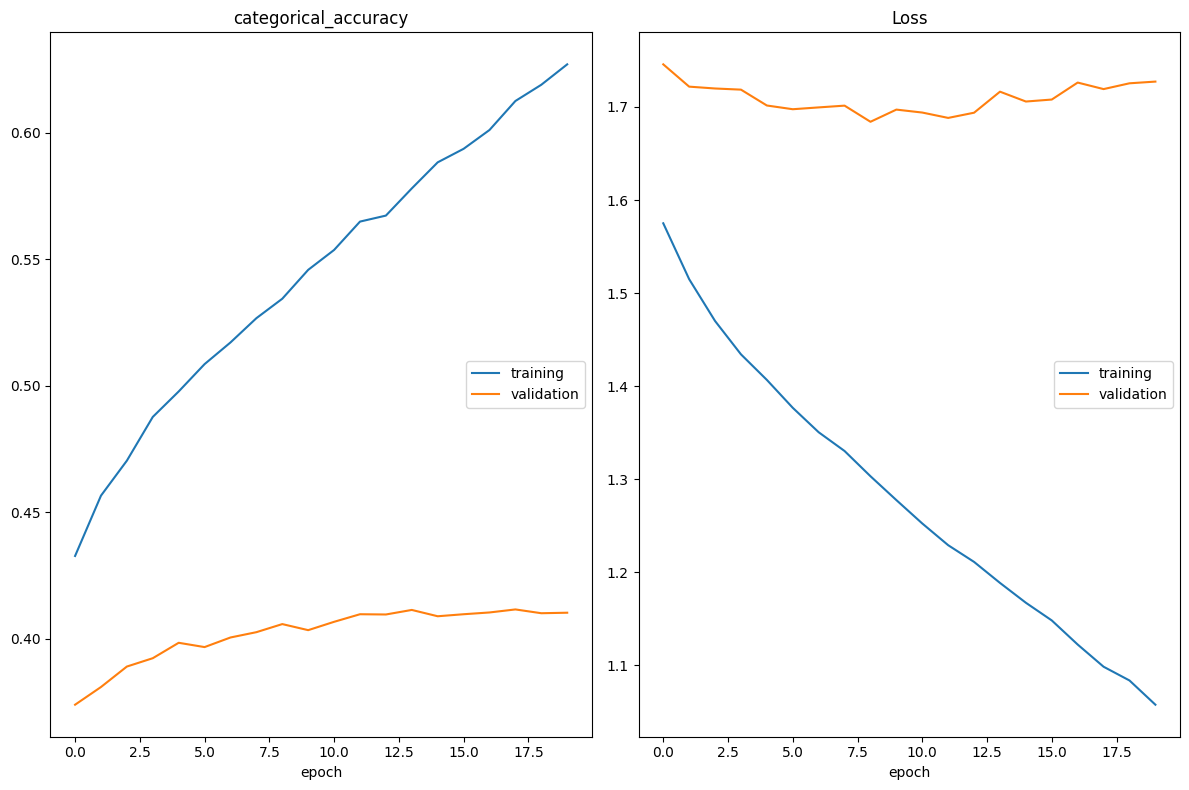

categorical_accuracy
	training         	 (min:    0.433, max:    0.627, cur:    0.627)
	validation       	 (min:    0.374, max:    0.412, cur:    0.410)
Loss
	training         	 (min:    1.058, max:    1.575, cur:    1.058)
	validation       	 (min:    1.684, max:    1.746, cur:    1.727)
626/626 [==============================] - 80s 127ms/step - loss: 1.0577 - categorical_accuracy: 0.6271 - val_loss: 1.7272 - val_categorical_accuracy: 0.4103


In [43]:
history = model_norm_aug.fit(x=train_ds,
                          epochs=EPOCHS,
                          validation_data=valid_ds,
                          callbacks=callbacks)

<b>Overfit again. Adding dropout.</b>

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
base_model.trainable = False

In [ ]:
augmentation_layer = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                          tf.keras.layers.RandomRotation(0.1),
                                          tf.keras.layers.RandomContrast(0.1)])

inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = augmentation_layer(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.AveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)
model_norm_aug = tf.keras.Model(inputs, outputs)

In [ ]:
LR = 1e-4
EPOCHS = 10

model_norm_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
                          loss='categorical_crossentropy',
                          metrics=['categorical_accuracy'])

In [ ]:
history_norm_aug = model_norm_aug.fit(x=train_ds,
                          epochs=EPOCHS,
                          validation_data=valid_ds,
                          callbacks=[PlotLossesKerasTF()])

In [ ]:
base_model.trainable = True

NON_TRAINABLE_LAYERS = 125
for layer in base_model.layers[:NON_TRAINABLE_LAYERS]:
    layer.trainable = False

In [ ]:
LR = 1e-5
EPOCHS = 20

model_norm_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
                          loss='categorical_crossentropy',
                          metrics=['categorical_accuracy'])

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=5),
             tf.keras.callbacks.ModelCheckpoint(filepath='models/model_06_norm_aug/checkpoints',
                                                save_weights_only=True,
                                                monitor='val_categorical_accuracy',
                                                mode='max',
                                                save_best_only=True),
             PlotLossesKerasTF()]

In [ ]:
history = model_norm_aug.fit(x=train_ds,
                          epochs=EPOCHS,
                          validation_data=valid_ds,
                          callbacks=callbacks)